<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Statistical Learning with Python</h1>
<h2 align="center" style="margin-top:20px">Lecture 3: Model Selection</h2>
<br>

The previous notebook left us with two important questions: how many neighbours should we use in the kNN method? Based on the training data, should we use the kNN algorithm or a linear regression as our final model? In this lesson we use cross-validation to address these questions. 

<a href="#1.-Credit-Card-Data">Credit Card Data</a> <br>
<a href="#2.-Cross-Validation">Cross Validation</a> <br>
<a href="#3.-Hyperparameter-Optimisation">Hyperparameter Optimisation</a> <br>
<a href="#4.-Choosing-the-Learning-Algorithm">Choosing the Learning Algorithm</a> <br>
<a href="#5.-Model-Evaluation">Model Evaluation</a> <br>

This notebook relies on the following imports and settings. We will load new functions and libraries in context to make clear what we are using them for. 

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 
# this is to clear the warnings from this page, usually we should leave this on

In [2]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(crayon) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Learning algorithms
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

### 1. Credit Card Data

We again use the `Credit` dataset. Here we simply repeat the steps from the previous notebook to load and process the data. 

In [4]:
# We will always assume that the data file is in a subdirectory called "Data"
train=pd.read_hdf('Data/Credit.h5', 'train')
test=pd.read_hdf('Data/Credit.h5', 'test')
train.head(10) 

Income  Limit  Cards  Age  Education  Student  Married  Balance  Male  \
Obs                                                                           
400   18.701   5524      5   64          7        0        0      966     0   
26    14.090   4323      5   25         16        0        1      671     0   
280   54.319   3063      3   59          8        1        0      269     0   
261   67.937   5184      4   63         12        0        1      345     1   
131   23.793   3821      4   56         12        1        1      868     0   
381  115.123   7760      3   83         14        0        0      661     0   
361   53.566   5891      4   82         10        0        0      712     0   
21    17.700   2860      4   63         16        0        0       89     0   
193   28.508   3933      4   56         14        0        1      336     1   
259   41.400   2561      2   36         14        0        1        0     1   

     Caucasian  Asian  
Obs                    
400          0      1  
26           0      0  
280          1      0  
261          0      1  
131          0      0  
381          0      0  
361          1      0  
21           0      1  
193          0      1  
259          1      0

We consider two predictors, the credit card limit and income. 

In [5]:
# Response label
response = 'Balance'

# Creates a list with the names of all variables which are not the respose
predictors = ['Limit','Income'] 

# Here we convert the data to NumPy arrays. This is not strictly necessary, but generally better.
y_train = train[response].to_numpy() 
X_train = train[predictors].to_numpy() 

y_test = test[response].to_numpy()
X_test = test[predictors].to_numpy() 

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

### 2. Cross Validation

As our first illustration, let's consider the choice of the number of neighbours. We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) to estimate the generalisation performance of the learning algorithm for different values of the hyperparameter.

The [<TT>cross_val_score</TT>](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from Scikit-Learn allows to computer the cross-validation error of a model.

In [7]:
knn = KNeighborsRegressor(n_neighbors=10, metric='mahalanobis', 
                          metric_params={'V': np.cov(X_train, rowvar=False)})

from sklearn.model_selection import cross_val_score
scores = cross_val_score(knn, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
scores

array([-46938.3375    , -13504.56482143, -18188.13589286, -39258.8625    ,
       -13452.49964286])

Note that we specified the following options: `cv=5` specifies the number of folds, while `scoring = 'neg_mean_squared_error'` specifies the evaluation criterion.

The function returns the score for each fold. Below, we average the scores and obtain the cross validation root mean squared error. 

In [8]:
rmse = np.sqrt(-1*np.mean(scores))
print(rmse)

162.0755381648587


The scoring in Scikit-Learn follows the convention that higher score values are better than lower values. This is why the argument in the function is the negative mean squared error. The Scikit-Learn [model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) documentation provides a list of scoring options. You should save this for future reference.

Often, the syntax is simplified by the fact that each method in Scikit-Learn has a default scoring method. In this case you have to consult the documentation to know what it is. For a [kNN regression] (http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) the default scoring is the r-squared.

Let's plot the cross validation error as a function of the hyperparameter. 

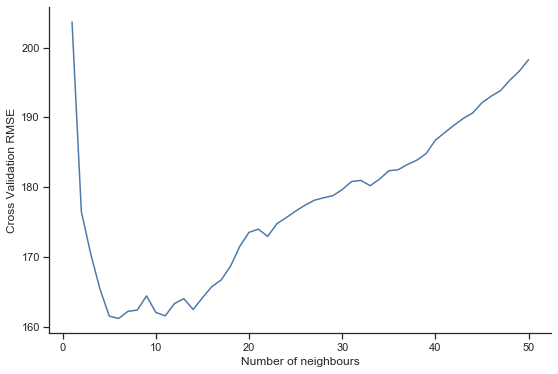

Lowest CV error: k = 6


In [9]:
n_neighbours=np.arange(1, 51)

cv_rmse = []
for k in n_neighbours: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', 
                          metric_params={'V': np.cov(X_train, rowvar=False)}) 
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(n_neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: k = {1 + np.argmin(cv_rmse)}')

Using $k=6$ neighbours therefore leads to the lowest cross-validation error. Below we will see how to automate the process of hyperparameter optimisation instead manually coding a loop. 

Our sample size here is not large,  and you can see above that there is a lot of variation in the MSE across folds. This is a situation in which we should use iterated k-fold cross validation, which we can do as follows.

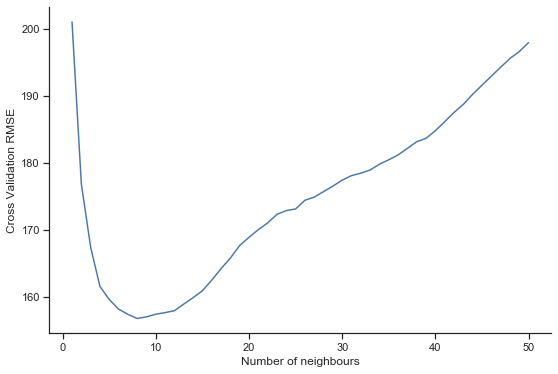

Lowest CV error: k = 8


In [10]:
from sklearn.model_selection import RepeatedKFold
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=44928)

n_neighbours=np.arange(1, 51)

cv_rmse = []
for k in n_neighbours: 
    model = KNeighborsRegressor(n_neighbors= k, metric='mahalanobis', 
                          metric_params={'V': np.cov(X_train, rowvar=False)}) 
    scores = cross_val_score(model, X_train, y_train, cv=rkf, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    cv_rmse.append(rmse)

fig, ax= plt.subplots()
ax.plot(n_neighbours, cv_rmse)
ax.set_xlabel('Number of neighbours')
ax.set_ylabel('Cross Validation RMSE')
sns.despine()
plt.show()
  
print(f'Lowest CV error: k = {1 + np.argmin(cv_rmse)}')

With iterated k-fold the curve looks much smoother! We now select $k=8$ neighbours instead of $k=6$. 

### 3. Hyperparameter Optimisation

Now, let's have a look at how we can automate hyperparameter optimisation. The grid search method solves our problem in the current setting, but it can too computationally costly when we work with large datasets and/or methods that have multiple tuning parameters. We therefore also show how you can use randomised search and Bayesian optimisation so that we can use these methods later when we need them. 

**3.1 Grid search**

We implement the grid search approach as follows (this is the same as what we did manually above).  

In [11]:
from sklearn.model_selection import GridSearchCV
 
# note that we skip specifying the hyperparameter that we want to choose
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)}) 

space = {'n_neighbors': np.arange(1,51),}

knn_search =  GridSearchCV(model, space, cv=rkf,  scoring = 'neg_mean_squared_error',  n_jobs=4)
knn_search.fit(X_train, y_train)

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x000001ED9261A828>,
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V': array([[1.00358, 0.8001 ],
       [0.8001 , 1.00358]])},
          n_jobs=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Setting `n_jobs=4` splits the task across four processor cores, which speeds up the computations. 

The following attribute allows us view the selected value of the parameter.  

In [12]:
knn_search.best_params_

{'n_neighbors': 8}

The selected model is stored in the `best_estimator_` attribute: 

In [13]:
knn_search.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='mahalanobis',
          metric_params={'V': array([[1.00358, 0.8001 ],
       [0.8001 , 1.00358]])},
          n_jobs=None, n_neighbors=8, p=2, weights='uniform')

**3.2 Randomised search**

The grid-search method solves our problem here, but it  can too computationally costly when we work with large datasets and/or methods that have multiple tuning parameters. In this case, we could instead use the  [<TT>RandomizedSearchCV</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) function, which evaluates only a random subset of hyperparameter configurations. 

The syntax is very similar to the above, except that we will often want to specify the <TT>n_iter</TT> option in order to control the computational budget for the parameter seach. Below, we specify that we would like to try twenty values for the number of neighbours. 

In [14]:
from sklearn.model_selection import RandomizedSearchCV

model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)})

space = {'n_neighbors': np.arange(1,101)}

knn_rs =  RandomizedSearchCV(model, space, cv=rkf,  n_iter=20, scoring = 'neg_mean_squared_error',
                             return_train_score=False, n_jobs=4, random_state=10)
knn_rs.fit(X_train, y_train)
knn_rs.best_params_ # because of the random search, the result may be different from what we got before

{'n_neighbors': 18}

**3.3 Bayesian Optimisation** 

Bayesian optimisation is a more advanced approach, both in terms of understanding how it works and the implementation. The most popular Python package for Bayesian optimisation among the machine learning community is [hyperopt](http://hyperopt.github.io/hyperopt/), which I encourage you to explore. However, I'll here use [scikit-optimize](http://hyperopt.github.io/hyperopt/) (you need to install it separately) because it simplifies things. 

In [15]:
from skopt.space import Integer
from skopt import BayesSearchCV

space = {'n_neighbors': Integer(1, 20)}
model = KNeighborsRegressor(metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)})
opt =  BayesSearchCV(model, space, cv= rkf,  n_iter=20, scoring = 'neg_mean_squared_error', n_jobs=4)
opt.fit(X_train, y_train)
opt.best_params_

{'n_neighbors': 8}

In Bayesian optimisation it's important to specify a range of values that you consider plausible, because this can change the result. 

 ### 4. Choosing a Learning Algorithm
 
Remember that our final choice of learning algorithm needs to be based on the training data only. We can compare methods in the model evaluation stage, but if we want to pick a final model to generate predictions for new data, we need to use model selection. 

Here, we compare the cross-validation RMSE of the linear regression and kNN algorithms and find that the latter performs best. This is therefore our final in the current setting. 

In [16]:
ols = LinearRegression()
knn = knn_search.best_estimator_
methods = [ols, knn] 

for method in methods:
    scores = cross_val_score(method, X_train, y_train, cv=rkf, scoring = 'neg_mean_squared_error')
    rmse = np.sqrt(-1*np.mean(scores))
    print(rmse)

158.66673877258523
156.8055200433691


### 5. Model evaluation
 
By carefully selecting the number of neighbours, we do bit better than arbitrarily choosing $k=10$ as we did in the previous notebook.

In [17]:
# Learning algorithms
ols = LinearRegression()
ols.fit(X_train, y_train)

knn1 = KNeighborsRegressor(n_neighbors = 10, metric='mahalanobis', 
                           metric_params={'V': np.cov(X_train, rowvar=False)})
knn1.fit(X_train, y_train)

knn2 = KNeighborsRegressor(n_neighbors = 15, metric='mahalanobis', 
                           metric_params={'V': np.cov(X_train, rowvar=False)})
knn2.fit(X_train, y_train)


# Initialise table
columns=['RMSE', 'R-Squared', 'MAE']
rows=['Linear Regression', 'kNN (k=10)', 'kNN (optimised)']
results =pd.DataFrame(0.0, columns=columns, index=rows)

# List of algorithms
methods = [ols, knn1, knn2] 

# Computer test predictions and metrics
for i, method in enumerate(methods):
    y_pred = method.predict(X_test)
    results.iloc[i, 0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i, 1] = r2_score(y_test, y_pred)
    results.iloc[i, 2] = mean_absolute_error(y_test, y_pred)

results.round(2)

RMSE  R-Squared     MAE
Linear Regression  182.45       0.84  135.65
kNN (k=10)         174.92       0.86  109.44
kNN (optimised)    179.05       0.85  113.29

In [18]:
# This cells formats the notebook for display online.  Please omit it from your work.  
from IPython.core.display import HTML
style = open('jstyle.css', "r").read()
HTML('<style>'+ style +'</style>')